<a href="https://colab.research.google.com/github/guillermohenrion/AI/blob/master/semantic_word_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Estudio de los textos de Hayek realizando un LDA, asignando semántica a las componentes dentro del espacio semántico según una word embedding y viendo la posición de cada documento. Similarmente para bigramas.

##Instalar e importar paquetes

In [1]:
!pip install nltk==3.5
!pip install gensim==4.1.2
!pip install spacy==3.1.5
!pip install pyLDAvis==3.2.1
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm
# !pip install feedparser
# !pip install gspan


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.4 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434690 sha256=c8c1565299468e3eb9f7cfdaeec3c6856c0fde505b4919acafa2bdab467dab51
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 68.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=5f8f5eff053705570b32b1afaa1ca6191e07ad187ec0617d9534f0a2b2bf3507
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 551 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.1 MB 573 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [2]:
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
# from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy

import csv
from unicodedata import normalize
import string
from wordcloud import WordCloud, STOPWORDS 
 
from sklearn.manifold import TSNE
#import gspan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import es_core_news_sm
nlp = es_core_news_sm.load()

#Leer documentos y procesar a txt

In [4]:
# '14_many_newlines_removed.txt'
# nombres_textos=['individualismo.txt','Hayek - A dónde va la democracia.txt','Hayek - Los principios de un orden social liberal.txt',
#               'Hayek - El uso del conocimiento en la sociedad.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt',
#              'Hayek - Camino de servidumbre.txt','Hayek - Precios y Producción.txt','Hayek - El mensaje de Adam Smith en el lenguaje actual.txt']

# nombres_textos=['Hayek - Individualismo.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt']

nombres_textos=['txts/Hayek - A donde va la democracia.txt', --1944
                'txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt', --1976
                'txts/Hayek - El uso del conocimiento en la sociedad.txt', --1945
                'txts/Hayek - Individualismo.txt', -- 1948
                'txts/Hayek - Liberalismo.txt',  -- 1973
                'txts/Hayek - Los principios de un orden social liberal.txt', --1966
                'txts/Hayek - Precios y Produccion.txt']  --1931

#'Hayek - Los Fundamentos de la Libertad.txt' da error en el preprocesamiento por superar 1M de caracteres

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !cp -r "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Hayek - Camino de servidumbre/" /content
!rsync -aP "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/txts" /content

sending incremental file list
txts/
txts/14_many_newlines_removed.txt
         66,094 100%   31.78MB/s    0:00:00 (xfr#1, to-chk=123/125)
txts/Hayek - A donde va la democracia.txt
         28,565 100%   41.14kB/s    0:00:00 (xfr#2, to-chk=122/125)
txts/Hayek - A dónde va la democracia.txt
         28,565 100%   23.60kB/s    0:00:01 (xfr#3, to-chk=121/125)
txts/Hayek - Camino de servidumbre.txt
        861,114 100%  112.85MB/s    0:00:00 (xfr#4, to-chk=120/125)
txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt
          8,134 100%   11.28kB/s    0:00:00 (xfr#5, to-chk=119/125)
txts/Hayek - El uso del conocimiento en la sociedad.txt
         36,511 100%   25.71kB/s    0:00:01 (xfr#6, to-chk=118/125)
txts/Hayek - Individualismo.txt
         64,752 100%   91.51kB/s    0:00:00 (xfr#7, to-chk=117/125)
txts/Hayek - La fatal arrogancia. Los errores del socialismo.txt
        586,768 100%  407.26kB/s    0:00:01 (xfr#8, to-chk=116/125)
txts/Hayek - Liberalismo.txt
         90,434 

In [7]:
import pandas as pd
doct=pd.DataFrame(columns=["Nombre", "Texto"])


In [8]:
doc=[]

for r in nombres_textos:
    with open(r,'r',encoding='latin1') as f:
        doc1=f.read()
        doc.append(doc1)
        df2 = {'Nombre': r, 'Texto': doc1}
        doct=doct.append(df2, ignore_index = True)


In [9]:
from os import listdir
from os.path import isfile, join

nombres_libros=['txts/Hayek - Camino de servidumbre',
                'txts/Hayek - La fatal arrogancia. Los errores del socialismo',
                'txts/Hayek - Los Fundamentos de la Libertad']

for l in nombres_libros:
    carpeta=l
    # carpeta_drive="drive/MyDrive/Colab Notebooks/"+carpeta
    # !cp -r carpeta_drive /content
    nombres_capitulos = [f for f in listdir(carpeta) if isfile(join(carpeta, f))]
    nombres_capitulos = [k for k in nombres_capitulos if 'txt' in k]
    
#     print(l)
    for r in nombres_capitulos:
        with open(f'{l}/'+r,'r',encoding='utf-8') as f:
            doc1=f.read()
            doc.append(doc1)
            df2 = {'Nombre': r, 'Texto': doc1}
            doct=doct.append(df2, ignore_index = True)


In [10]:
doct.loc[doct['Nombre'] == "txts/Hayek - A donde va la democracia.txt"]


,Nombre,Texto
0,txts/Hayek - A donde va la democracia.txt,¿Adónde va la democracia?\nFriedrich A. Hayek\...


In [11]:
def preprocessing(text,stopwords):
    text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                  normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
    text = normalize('NFC', text)  # NFC
    bigram_list = bigram[text.split()]
    out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # ,'VERB','ADJ', 'PROPN'
    text_non_stop = [word for word in out_text if word not in stopwords]

    return text_non_stop

def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in allowed_postags]
                 #allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')

def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

#BOW

In [12]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [13]:
stopwords = nltk.corpus.stopwords.words('spanish')
bigram = gensim.models.Phrases(doc, min_count=5, threshold=2.0)
stopwords.extend(['vez','pagina','parte','ejemplo','medida','modo','tipo','forma','punto','hecho','parrafo','mas','hayek','lugar','embargo','caso','solo',
                 'fin','medio','año','inter'])

In [14]:
bow=[]
frecuenciaPalab_docs=[]

for i,d in enumerate(doc):
    # print(i)
    bow.append(preprocessing(d, stopwords))

    frecuenciaPalab = []
    for w in bow[i]:
        frecuenciaPalab.append(bow[i].count(w))

    frecuenciaPalab_docs.append(frecuenciaPalab)
    
# print("Lista\n" + str(bow[0]) + "\n")
# print("Frecuencias\n" + str(frecuenciaPalab_docs[0]) + "\n")
# print("Pares\n" + str(list(zip(bow[0], frecuenciaPalab_docs[0]))))

In [15]:
corpus_completo=[]
for d in bow:
    corpus_completo+=d

corpus_completo_palabras=set(corpus_completo)
len(corpus_completo_palabras)

8542

In [116]:
corpus_1=[]
corpus_2=[]

i=0
for d in bow:
    if i in (0,2,3,6):
        corpus_1+=d
    if i in (1,4,5):
        corpus_2+=d
    i=i+1

corpus_1_palabras=set(corpus_1)
print(len(corpus_1_palabras))
corpus_2_palabras=set(corpus_2)
len(corpus_2_palabras)

2345


1383

In [16]:
frecuenciaPalab_completo = []
for w in corpus_completo_palabras:
    frecuenciaPalab_completo.append(corpus_completo.count(w))

In [17]:
#20 palabras más populares todo el corpus
frec_df=pd.DataFrame(list(zip(corpus_completo_palabras,frecuenciaPalab_completo)))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)


,palabra,frec
7465,libertad,1310
4423,ley,980
7656,poder,953
3725,bien,757
4659,sociedad,752
3337,individuo,731
7791,hombre,706
531,orden,691
818,proceso,670
5585,precio,650


In [18]:
# corpus_completo

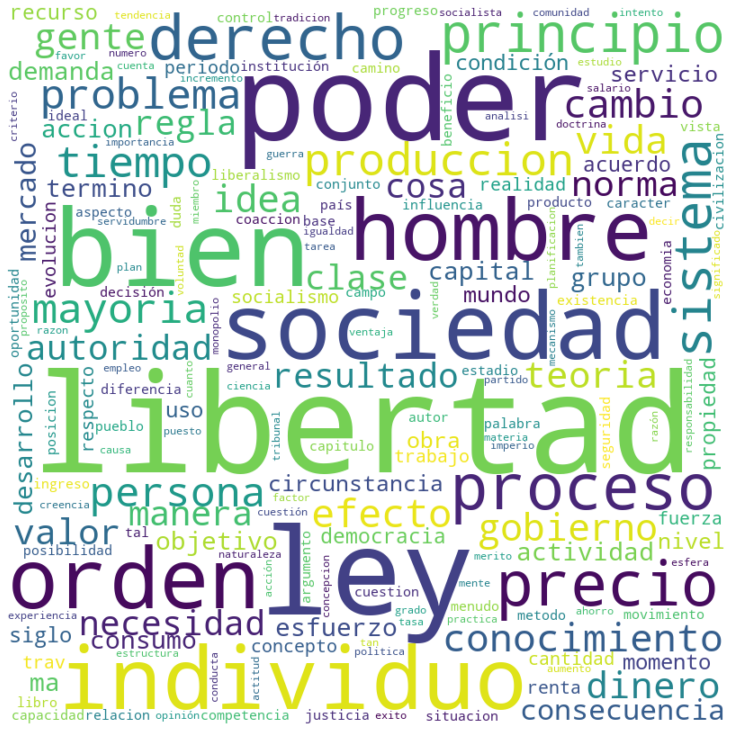

In [19]:
text = " ".join(corpus_completo)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [20]:
frec_df=pd.DataFrame(list(zip(bow[0], frecuenciaPalab_docs[0])))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)

,palabra,frec
21,gobierno,46
120,asamblea,43
128,ley,36
34,poder,35
0,democracia,34
20,mayoria,30
166,norma,20
271,autoridad,13
91,tiempo,10
137,apoyo,10


#Display semantic space

In [21]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 6), (1, 1), (2, 2), (3, 4), (4, 7), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 10), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 43), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 13)]


In [22]:
!cp "drive/MyDrive/Colab Notebooks/Historical Text Analytics/embbedings/SBW-vectors-300-min5.txt" /content


In [23]:
model = gensim.models.KeyedVectors.load_word2vec_format("SBW-vectors-300-min5.txt", binary=False)

In [24]:
data=model.most_similar(positive=['crédito', 'hombre']) 

In [25]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords) 

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


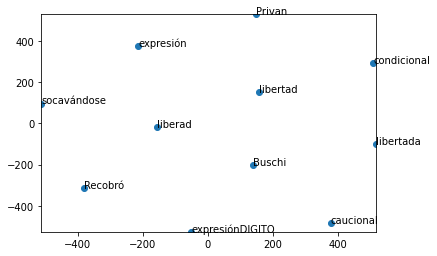

In [26]:
display_closestwords_tsnescatterplot(model, "libertad")

#Análisis de n-grams

In [27]:
def initialize_ngram_finder(list_of_tokens):
    """
    This function will initialize ngram finders for both bigrams & trigrams.
    
    arguments:
        input_text: "list_of_tokens" of type "list" containing all alphanum tokens for each article.
                    
    return:
        value: "bigrams", "trigrams", "bigramFinder", "trigramFinder"
        
    """
    # A number of standard association
    # measures are provided in BigramAssocMeasures and TrigramAssocMeasures.
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    
    # BigramCollocationFinder --> A tool for the finding and ranking of Bigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    # TrigramCollocationFinder --> A tool for the finding and ranking of trigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    return bigrams, trigrams, bigramFinder, trigramFinder


In [28]:
# bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(bow[1])
bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(corpus_completo)

In [29]:
def freq_counting_bigram(bigramFinder):
    """
    This function will count how many times adjacent words co-occurs as bigrams.
    
    arguments:
        input_text: "bigramFinder" of type "nltk.collocations.BigramCollocationFinder". 
                    
    return:
        value: "bigramFreqTable" of type "pandas Dataframe" 
                containing bigrams and their corresponding frequencies.
        
    """
    # Generate list of bigrams w.r.t their frequency.
    bigram_freq = bigramFinder.ngram_fd.items()
    # Create Dataframe having bigrams as one column & their corresponding frequency as other column 
    # sorted in descending order of frequency.
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    freq_bi = bigramFreqTable[:100].bigram.values
    return bigramFreqTable, freq_bi


In [30]:
bigramFreqTable, freq_bi = freq_counting_bigram(bigramFinder)
bigramFreqTable.head(10).reset_index(drop=True)


,bigram,freq
0,"(bien, consumo)",237
1,"(libertad, libertad)",178
2,"(demanda, bien)",156
3,"(camino, servidumbre)",131
4,"(imperio, ley)",129
5,"(bien, produccion)",122
6,"(produccion, bien)",115
7,"(cantidad, dinero)",100
8,"(precio, bien)",97
9,"(demanda, consumo)",89


In [31]:
bigramFreqTable

,bigram,freq
4082,"(bien, consumo)",237
8479,"(libertad, libertad)",178
16722,"(demanda, bien)",156
34287,"(camino, servidumbre)",131
287,"(imperio, ley)",129
...,...,...
61101,"(organismo, orden)",1
61100,"(organismo, prosperidad)",1
61098,"(nivel, organismo)",1
61094,"(asistamo, esfuerzo)",1


In [32]:
bigramFreqTable_dict=dict(zip(bigramFreqTable.bigram, bigramFreqTable.freq))
# bigramFreqTable_dict

In [33]:
trigramFreqTable, freq_tri = freq_counting_bigram(trigramFinder)
trigramFreqTable.head(10).reset_index(drop=True)

,bigram,freq
0,"(demanda, bien, consumo)",85
1,"(produccion, bien, consumo)",37
2,"(demanda, bien, produccion)",33
3,"(precio, bien, consumo)",30
4,"(cambio, cantidad, dinero)",22
5,"(bien, consumo, demanda)",17
6,"(bien, consumo, bien)",17
7,"(incremento, demanda, bien)",15
8,"(demanda, bien, capital)",14
9,"(libertad, libertad, libertad)",14


In [34]:
# freq_bi=freq_bi.reshape(-1,1)
# freq_bi.shape

freq_bi=list(freq_bi)
freq_bi_comp=[]
freq_bi_comp.append(freq_bi)

In [35]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import models

docs = ['new york is is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ')
# bigram = Phrases(bow, min_count=5, threshold=2,delimiter=b' ')

# bigram_phraser = Phraser(bigram)
# bigram_token = []
# for sent in token_:
#     bigram_token.append(bigram_phraser[sent])

phrases = Phrases(bow,min_count=2)
bigrams = Phraser(phrases)    
# bigrams

bigram_token = []
for sent in bow:
    bigram_token.append(bigrams[sent])

# for doc in bow:
#     bigrams_doc = list(ngrams(doc, 2)) 
#     bigram_token.append(bigrams_doc)

In [36]:
corpus_completo_bigramas=[]
for d in bigram_token:
    corpus_completo_bigramas+=d

# corpus_completo_palabras=set(corpus_completo)
# len(corpus_completo_palabras)

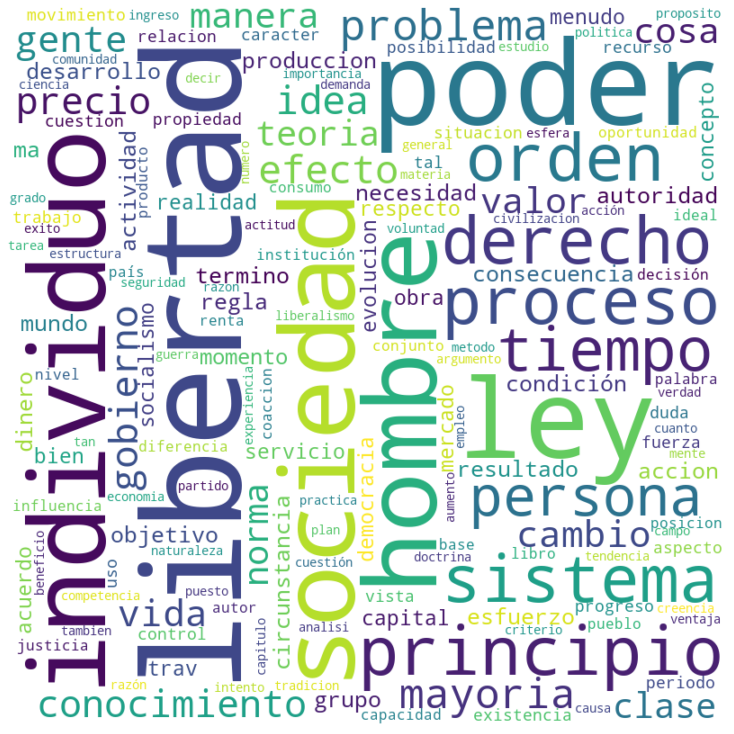

In [37]:
#Todo incluyendo bigramas

text = " ".join(corpus_completo_bigramas)
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [38]:
corpus_completo_bigramas2=list(filter(lambda k: '_' in k, corpus_completo_bigramas))
corpus_completo_bigramas2 = [ele for ele in corpus_completo_bigramas2 if not(ele in 'camino_servidumbre')]

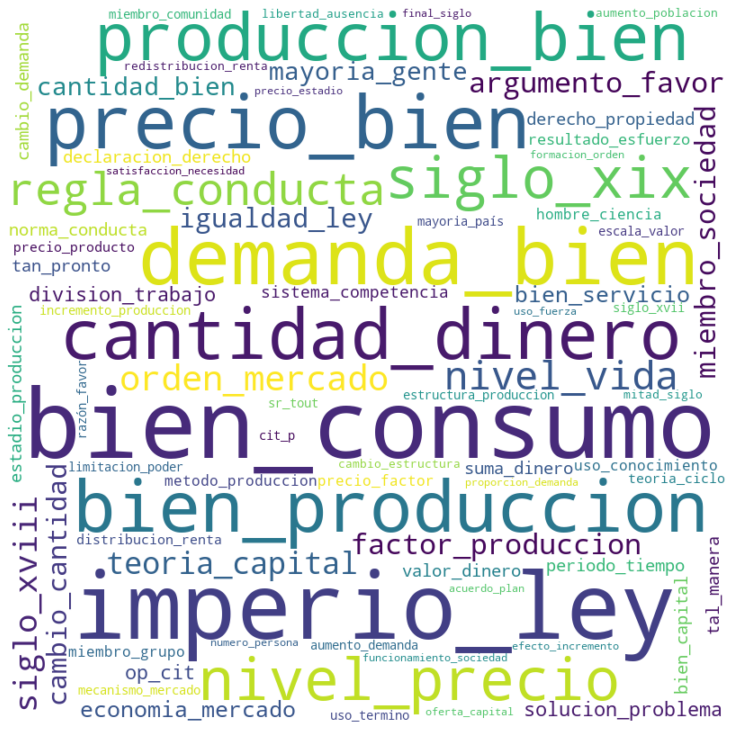

In [39]:
#Solo bigramas
text = " ".join(corpus_completo_bigramas2)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [40]:
# id2word = corpora.Dictionary(bow)

# # Term Document Frequency
# corpus = [id2word.doc2bow(t) for t in bow]


import gensim.corpora as corpora

#Listado de bigramas únicos
id2word_bi = corpora.Dictionary(bigram_token)

# Term Document Frequency
corpus_bi = [id2word_bi.doc2bow(t) for t in bigram_token]

# View
print(corpus_bi[:1][0][:30])


[(0, 5), (1, 1), (2, 2), (3, 2), (4, 2), (5, 7), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 10), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 37), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1)]


In [41]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 6), (1, 1), (2, 2), (3, 4), (4, 7), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 10), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 43), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 13)]


#LDA

In [42]:
%%time

from pprint import pprint

# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"libertad" + 0.010*"precio" + 0.008*"bien" + 0.008*"poder" + '
  '0.008*"produccion" + 0.006*"hombre" + 0.006*"sociedad" + 0.006*"sistema" + '
  '0.006*"ley" + 0.006*"proceso"'),
 (1,
  '0.011*"ley" + 0.008*"poder" + 0.008*"libertad" + 0.007*"principio" + '
  '0.006*"individuo" + 0.006*"sociedad" + 0.006*"proceso" + 0.006*"problema" + '
  '0.005*"derecho" + 0.005*"bien"'),
 (2,
  '0.009*"ley" + 0.009*"poder" + 0.009*"libertad" + 0.007*"orden" + '
  '0.007*"sociedad" + 0.007*"individuo" + 0.007*"hombre" + 0.006*"derecho" + '
  '0.006*"bien" + 0.006*"proceso"')]
CPU times: user 587 ms, sys: 84.8 ms, total: 672 ms
Wall time: 733 ms


In [43]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005601  0.003369       1        1  59.322113
0      0.008623  0.000746       2        1  26.221037
1     -0.003023 -0.004115       3        1  14.456850, topic_info=          Term         Freq        Total Category  logprob  loglift
209   libertad  1200.000000  1200.000000  Default  30.0000  30.0000
208        ley   889.000000   889.000000  Default  29.0000  29.0000
280     precio   601.000000   601.000000  Default  28.0000  28.0000
273      poder   889.000000   889.000000  Default  27.0000  27.0000
287  principio   566.000000   566.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
36      cambio    55.950991   446.561615   Topic3  -5.6159  -0.1431
164      gente    53.278775   403.815827   Topic3  -5.6648  -0.0914
280     precio    54.633027   601.090317   Topic3  -5.6397  -0.4641
493     teoria    50.552077   390.551802   Topic3  -5.7174  -0.1106
241      norma    50.063684   393.897624   Topic3  -5.7271  -0.1288

[287 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.638717     accion
0         2  0.192629     accion
0         3  0.165593     accion
2         1  0.667431  actividad
2         2  0.226504  actividad
...     ...       ...        ...
5927      2  0.576871     volvia
5929      2  0.576953       waas
4319      1  0.620549     wilcox
4319      2  0.620549     wilcox
5931      2  0.577549         ²⁶

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

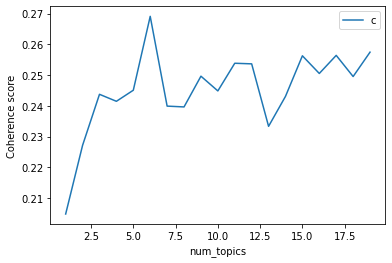

([<gensim.models.ldamodel.LdaModel at 0x7fe54d2bf2d0>,
 [0.20483435892834798,
  0.227177865692909,
  0.24378284583610865,
  0.24150589401380598,
  0.2451095391453959,
  0.2691506225456586,
  0.239939615945805,
  0.23967446262302838,
  0.2496767425186791,
  0.24488403029937192,
  0.2538864357289346,
  0.2536899355157019,
  0.23336598257085925,
  0.2431136501817001,
  0.25631328769243844,
  0.25056216882292826,
  0.25644861502426974,
  0.24956674290634284,
  0.25749582480915684])

In [44]:
evaluate_graph(id2word,corpus,bow,20,'lda')

In [45]:
lda_model.show_topics()


[(0,
  '0.019*"libertad" + 0.010*"precio" + 0.008*"bien" + 0.008*"poder" + 0.008*"produccion" + 0.006*"hombre" + 0.006*"sociedad" + 0.006*"sistema" + 0.006*"ley" + 0.006*"proceso"'),
 (1,
  '0.011*"ley" + 0.008*"poder" + 0.008*"libertad" + 0.007*"principio" + 0.006*"individuo" + 0.006*"sociedad" + 0.006*"proceso" + 0.006*"problema" + 0.005*"derecho" + 0.005*"bien"'),
 (2,
  '0.009*"ley" + 0.009*"poder" + 0.009*"libertad" + 0.007*"orden" + 0.007*"sociedad" + 0.007*"individuo" + 0.007*"hombre" + 0.006*"derecho" + 0.006*"bien" + 0.006*"proceso"')]

#LDA con bigramas


In [46]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model_bi = gensim.models.LdaMulticore(corpus=corpus_bi,
                                       id2word=id2word_bi,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model_bi.print_topics())
doc_lda_bi = lda_model_bi[corpus]
lda_model_bi[corpus[0]]

[(0,
  '0.010*"libertad" + 0.008*"principio" + 0.007*"derecho" + 0.007*"poder" + '
  '0.007*"ley" + 0.006*"cambio" + 0.006*"sociedad" + 0.006*"problema" + '
  '0.006*"individuo" + 0.005*"tiempo"'),
 (1,
  '0.018*"libertad" + 0.018*"ley" + 0.011*"individuo" + 0.010*"derecho" + '
  '0.009*"poder" + 0.007*"hombre" + 0.007*"regla" + 0.006*"principio" + '
  '0.006*"sociedad" + 0.005*"persona"'),
 (2,
  '0.007*"proceso" + 0.006*"sociedad" + 0.006*"individuo" + 0.006*"orden" + '
  '0.006*"precio" + 0.006*"hombre" + 0.006*"libertad" + 0.005*"problema" + '
  '0.005*"produccion" + 0.005*"poder"'),
 (3,
  '0.015*"poder" + 0.012*"libertad" + 0.008*"ley" + 0.008*"hombre" + '
  '0.008*"individuo" + 0.008*"mayoria" + 0.007*"principio" + 0.007*"sistema" + '
  '0.007*"sociedad" + 0.007*"persona"'),
 (4,
  '0.009*"libertad" + 0.007*"proceso" + 0.007*"precio" + 0.007*"dinero" + '
  '0.007*"efecto" + 0.007*"produccion" + 0.006*"teoria" + 0.006*"problema" + '
  '0.006*"tiempo" + 0.005*"cambio"'),
 (5,
  '0

[(3, 0.9990446)]

In [47]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared_bi = pyLDAvis.gensim.prepare(lda_model_bi, corpus_bi, id2word_bi)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared_bi

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.040259  0.000136       1        1  36.463532
4      0.022090  0.018981       2        1  19.220464
6     -0.011430  0.009154       3        1  14.819956
9      0.002595  0.006751       4        1   9.648401
5     -0.016603  0.001863       5        1   8.218577
1     -0.019378 -0.012005       6        1   7.663818
0      0.001834 -0.002969       7        1   3.015785
8      0.007450 -0.015734       8        1   0.533523
2      0.008942  0.003610       9        1   0.409872
7      0.044759 -0.009787      10        1   0.006071, topic_info=           Term         Freq        Total Category  logprob  loglift
215    libertad  1224.000000  1224.000000  Default  30.0000  30.0000
282       poder   932.000000   932.000000  Default  29.0000  29.0000
214         ley   747.000000   747.000000  Default  28.0000  28.0000
300     proceso   544.000000   544.000000  Default  27.0000  27.0000
195   individuo   706.000000   706.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
215    libertad     0.018964  1224.584648  Topic10  -5.7751  -1.3662
114  desarrollo     0.014421   305.191255  Topic10  -6.0489  -0.2506
348     sistema     0.015945   593.330732  Topic10  -5.9485  -0.8150
451        idea     0.014540   390.425344  Topic10  -6.0407  -0.4887
381       valor     0.013997   350.881309  Topic10  -6.0788  -0.4200

[849 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2218      2  0.690102  abcisa
0         1  0.396555  accion
0         2  0.121749  accion
0         3  0.153057  accion
0         4  0.062614  accion
...     ...       ...     ...
4947      3  0.257314    zona
4947      4  0.032164    zona
4947      5  0.192986    zona
4947      6  0.064329    zona
4947      7  0.032164    zona

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 10, 6, 2, 1, 9, 3, 8])

#Tópicos dentro el espacio semántico

In [48]:
import numpy as np
from gensim.test.utils import datapath
from gensim import utils

l = np.array([0.017*model.get_vector("libertad"), 0.009*model.get_vector("precio"), 0.008*model.get_vector("poder"),0.007*model.get_vector("bien"),0.007*model.get_vector("hombre"), 0.006*model.get_vector("produccion"), 0.006*model.get_vector("ley")])


In [49]:
from numpy import *
def randCent(dataSet, k, s):
    n = shape(dataSet)[1]
    centroids = mat(zeros(n))
    for j in range(n):
        centroids[:,j] = np.sum(dataSet[:,j])
    return centroids/s

In [50]:
s=0.017+0.009+0.008+0.007+0.007+0.006+0.006
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [51]:
model.similar_by_vector(centroid)

[('libertad', 0.7767316102981567),
 ('creérsele', 0.7446049451828003),
 ('socavándose', 0.7387365102767944),
 ('lucharlas', 0.735815167427063),
 ('monopolizarla', 0.7315989136695862),
 ('coartara', 0.7308528423309326),
 ('restituirnos', 0.7286457419395447),
 ('encausarla', 0.7283784747123718),
 ('desposeidos', 0.7270509600639343),
 ('Averiguan', 0.7263656258583069)]

In [52]:
s=0.011+0.009+0.008+0.007+0.006+0.006+0.006
l = np.array([0.011*model.get_vector("ley"), 0.009*model.get_vector("libertad"), 0.008*model.get_vector("poder"),0.007*model.get_vector("principio"),0.006*model.get_vector("individuo"), 0.006*model.get_vector("sociedad"), 0.006*model.get_vector("proceso")])
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [53]:
model.similar_by_vector(centroid)

[('coartara', 0.7556817531585693),
 ('separársele', 0.744306206703186),
 ('socavándose', 0.7419633269309998),
 ('portaliano', 0.7410425543785095),
 ('Guzmancista', 0.7404754161834717),
 ('Sustentados', 0.7395446300506592),
 ('comprobársele', 0.7392594218254089),
 ('narcotización', 0.7388145327568054),
 ('principismo', 0.7371867895126343),
 ('podérsele', 0.7356439232826233)]

#Documentos en espacio LDA y espacio semántico

In [54]:
lda_model[corpus[20]]

[(0, 0.9988823)]

In [88]:
lda_model_app=[]
for d in corpus:
  lda_model_app.append(lda_model[d])

pd.DataFrame(lda_model_app)

,0,1,2
0,"(2, 0.99916476)",None,None
1,"(2, 0.9972656)",None,None
2,"(2, 0.9989715)",None,None
3,"(2, 0.99961096)",None,None
4,"(2, 0.99972355)",None,None
...,...,...,...
56,"(0, 0.38368946)","(1, 0.46710306)","(2, 0.14920743)"
57,"(0, 0.2701918)","(2, 0.72674596)",None
58,"(2, 0.9994284)",None,None
59,"(2, 0.99941725)",None,None


#Collocation


In [114]:
from nltk import FreqDist

# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, ngrams
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

bigram_collocation = BigramCollocationFinder.from_words(corpus_completo, 3)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 3))

trigram_collocation = TrigramCollocationFinder.from_words(corpus_completo, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 3))

trigram_collocation2 = TrigramCollocationFinder.from_words(bow[0], 3)
print(trigram_collocation2.nbest(TrigramAssocMeasures.likelihood_ratio, 3))

print(trigram_collocation.ngram_fd[('produccion', 'bien', 'consumo')])
bigram_collocation.ngram_fd[('camino', 'servidumbre')]


[('bien', 'consumo'), ('camino', 'servidumbre'), ('demanda', 'bien')]
[('demanda', 'bien', 'consumo'), ('precio', 'bien', 'consumo'), ('produccion', 'bien', 'consumo')]
[('compromiso', 'norma', 'conducta'), ('obediencia', 'norma', 'conducta'), ('autoridad', 'compromiso', 'norma')]
37


131

In [122]:


trigram_collocation_1 = TrigramCollocationFinder.from_words(corpus_1, 3)
print(trigram_collocation_1.nbest(TrigramAssocMeasures.likelihood_ratio, 3))

trigram_collocation_2 = TrigramCollocationFinder.from_words(corpus_2, 3)
print(trigram_collocation_2.nbest(TrigramAssocMeasures.likelihood_ratio, 3))


print(trigram_collocation_1.ngram_fd[('precio', 'bien', 'consumo')])
print(trigram_collocation_2.ngram_fd[('regla', 'conducta', 'individuo')])


[('demanda', 'bien', 'consumo'), ('precio', 'bien', 'consumo'), ('produccion', 'bien', 'consumo')]
[('ejecucion', 'regla', 'conducta'), ('regla', 'conducta', 'individuo'), ('ultimo', 'regla', 'conducta')]
30
2
